# Operations Data Analyst Challenge

In [1]:
# Importing Liraries required to complete pur analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, warnings, calendar
# Ignoring warnings for functions which will be deprecated in near future
warnings.filterwarnings('ignore')

In [2]:
# Importing all the datasets from csv to pandas dataframe
contacts = pd.read_csv(r"G:\My Drive\Old Laptop\Downloads\Personal\N26\ops_case_study__contacts.csv")
specialists = pd.read_csv(r"G:\My Drive\Old Laptop\Downloads\Personal\N26\ops_case_study__specialists.csv")
users = pd.read_csv(r"G:\My Drive\Old Laptop\Downloads\Personal\N26\ops_case_study__users.csv")
surveys = pd.read_csv(r"G:\My Drive\Old Laptop\Downloads\Personal\N26\ops_case_study__surveys.csv")

## Data Preprocessing
### Creating necessary columns which will be required in further analysis

#### - Contacts transaction table processing

In [3]:
# changing data type of "initiated_date" column to datetime
contacts[['contact_date','initiated_date']] = contacts[['contact_date','initiated_date']].apply(pd.to_datetime, format='%Y-%m-%d')

# parsing day number from date column
contacts["contact_#_of_date"] = pd.DatetimeIndex(contacts["contact_date"]).day
contacts["initiated_#_of_date"] = pd.DatetimeIndex(contacts["initiated_date"]).day
contacts['contact_#_of_date'] = contacts['contact_#_of_date'].fillna(0).astype(int)

# parsing day name from date column
contacts["Name_of_day"] = pd.DatetimeIndex(contacts["initiated_date"]).day_name()

# parsing week number from date column
contacts['Week_Number'] = contacts['initiated_date'].dt.week

#### - Surveys response table processing

In [4]:
# changing data type of "initiated_date" column to datetime
surveys["response_date"]=surveys["response_date"].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

# Considering only survey responses from month of june to be aligned with the Contacts transaction table
surveys = surveys[surveys['response_date'].dt.month == 6]

# parsing day name from date column
surveys["Name_of_day"] = pd.DatetimeIndex(surveys["response_date"]).day_name()

# parsing week number from date column
surveys['Week_Number'] = surveys['response_date'].dt.week

# sorting data on week number
surveys = surveys.sort_values(by=['Week_Number'])

## 1.A High level overview of what happened in Customer Service.

#### -- Over view of specialist resource by InHouse

In [5]:
# Printing total # of resources
print ("Total # of resources:    \n        "+str(specialists['id'].count()))

Total # of resources:    
        202


In [6]:
# Counting the total resources split by In-House category
specialists.groupby(['is_inhouse'])["id"].count()

is_inhouse
False    122
True      80
Name: id, dtype: int64

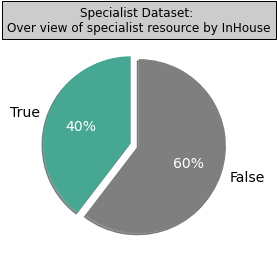

In [7]:
# Plotting pie chart and visualizing the # of resource based on In-House category
specialists_D = specialists.groupby(['is_inhouse']).count()
specialists_D = specialists_D.reset_index()

explode = [0, 0.1]
palette_color = sns.color_palette('dark')
_, _, autotexts = plt.pie(specialists_D["full_name"], labels=specialists_D["is_inhouse"],
                           counterclock=False, shadow=True, explode=explode,
                          textprops={'fontsize': 14},autopct='%.0f%%',startangle=90,colors=['#7F7F7F','#46A793'])

for autotext in autotexts:
    autotext.set_color('white')
plt.title("Specialist Dataset: \n" + "Over view of specialist resource by InHouse", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

According to data, 60% of our CS resourse is from external customer service center and 40% resource belongs to InHouse

#### -- Specialists who can interact with customers in more then 2 languages 

In [8]:
# We will not use transaction data where the calls were abandoned
Language_Count = contacts[contacts["abandoned"]==False]
# Count distinct language code for each of the Specialist
Language_Count = contacts.groupby(['specialist_id'])['contact_language'].nunique()
Language_Count = pd.DataFrame(Language_Count)
Language_Count = Language_Count.reset_index().sort_values(by=['contact_language'], ascending=False)
Language_Count.head(15)

,specialist_id,contact_language
115,s202,5
114,s201,5
47,s141,4
31,s127,4
173,s73,4
183,s82,4
26,s122,4
57,s150,3
64,s157,3
21,s118,3


In [9]:
# joining the count data with specialists main table to extract full name of specialists
contacts_name = pd.merge(Language_Count,specialists[["id","full_name"]],
                                how='left',left_on='specialist_id',right_on='id')

In [10]:
# Only picking relevant columns
Language_Count = contacts_name[["specialist_id","full_name","contact_language"]]
# Dropping rows where full names are not real
Language_Count = Language_Count[Language_Count["full_name"].str.contains("CALL QUEUE")==False]
Language_Count = Language_Count[Language_Count["full_name"].str.contains("CHAT QUEUE")==False]
# Only considering specialist which can speak more than 2 languages
Language_Count = Language_Count[Language_Count["contact_language"]> 2]
Language_Count.head(7)

,specialist_id,full_name,contact_language
2,s141,Andrew Garfield,4
3,s127,Jessica Alba,4
4,s73,Elizabeth Taylor,4
5,s82,Alex Rodriguez,4
6,s122,Nicki Minaj,4
7,s150,Justin Timberlake,3
8,s157,Barack Obama,3


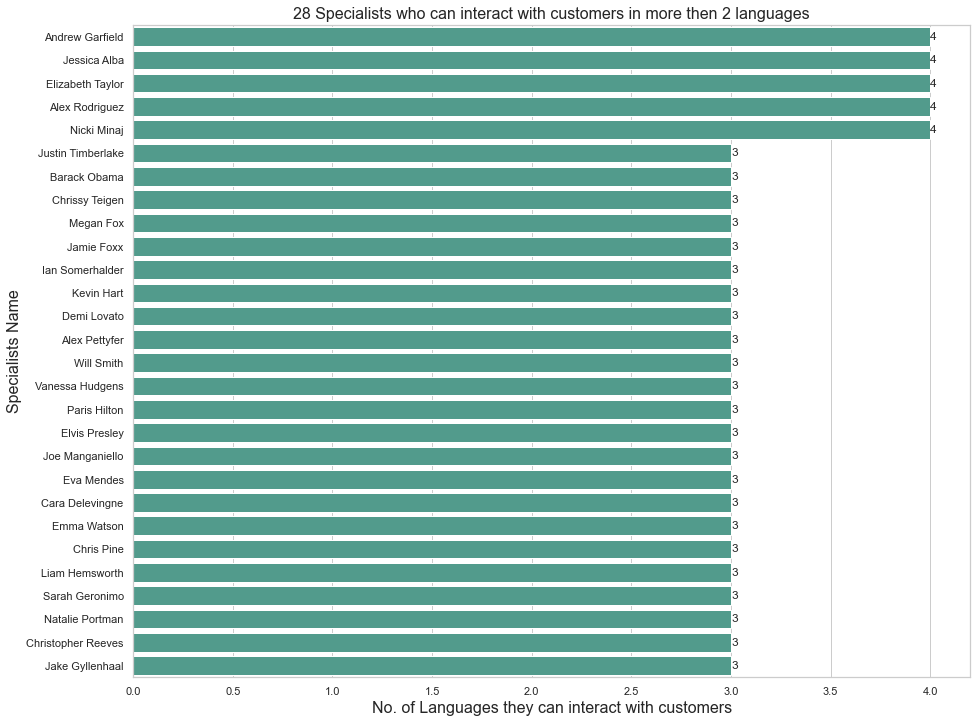

In [11]:
# Plotting the data in a bar chart
plt.figure(figsize=(15, 12))
sns.set(style="whitegrid", color_codes=True)
splot=sns.barplot(x="contact_language",y="full_name",data=Language_Count, color='#46A793')
plt.title('28 Specialists who can interact with customers in more then 2 languages', size=16)
plt.xlabel("No. of Languages they can interact with customers", size=16)
plt.ylabel("Specialists Name", size=16)
plt.bar_label(splot.containers[0])
plt.savefig("annotate_barplot_with_Matplotlib_bar_label_Python.png")

#### -- Top 10 Specialists by average # of transactions per day

In [12]:
# Counting no. of transactions for each specialists
Count_Txns = contacts.groupby(['specialist_id'])['specialist_id'].count()
Count_Txns = pd.DataFrame(Count_Txns)
Count_Txns.rename(columns = {'specialist_id':'# of transactions'}, inplace = True)
Count_Txns = Count_Txns.reset_index().sort_values(by=['# of transactions'], ascending=False)
Count_Txns

,specialist_id,# of transactions
114,s201,8901
59,s152,815
123,s28,782
72,s164,762
140,s43,746
...,...,...
193,s91,3
147,s5,2
177,s77,2
144,s47,2


In [13]:
# joining the count data with specialists main table to extract full name of specialists
Count_Txns_name = pd.merge(Count_Txns,specialists[["id","full_name"]],
                                how='left',left_on='specialist_id',right_on='id')
# June month contains 30 days. Dividing by by 30 to get avaerage # of transactions for each specialists
Count_Txns_name["Avg # of transactions per day"] = (Count_Txns_name["# of transactions"]/30).round(2)
Count_Txns_name = Count_Txns_name[Count_Txns_name["full_name"].str.contains("CALL QUEUE")==False]
Count_Txns_name = Count_Txns_name[Count_Txns_name["full_name"].str.contains("CHAT QUEUE")==False]
Count_Txns_name = Count_Txns_name[["specialist_id","full_name","Avg # of transactions per day"]].head(10)
Count_Txns_name

,specialist_id,full_name,Avg # of transactions per day
1,s152,Ryan Reynolds,27.17
2,s28,Chris Hemsworth,26.07
3,s164,Marilyn Monroe,25.40
4,s43,Tiger Woods,24.87
5,s42,Eva Mendes,24.63
6,s72,Leonardo Di Caprio,23.50
7,s174,Robert De Niro,23.17
8,s67,Megan Fox,23.00
9,s44,K.S. Chithra,22.87
10,s79,Liam Hemsworth,21.57


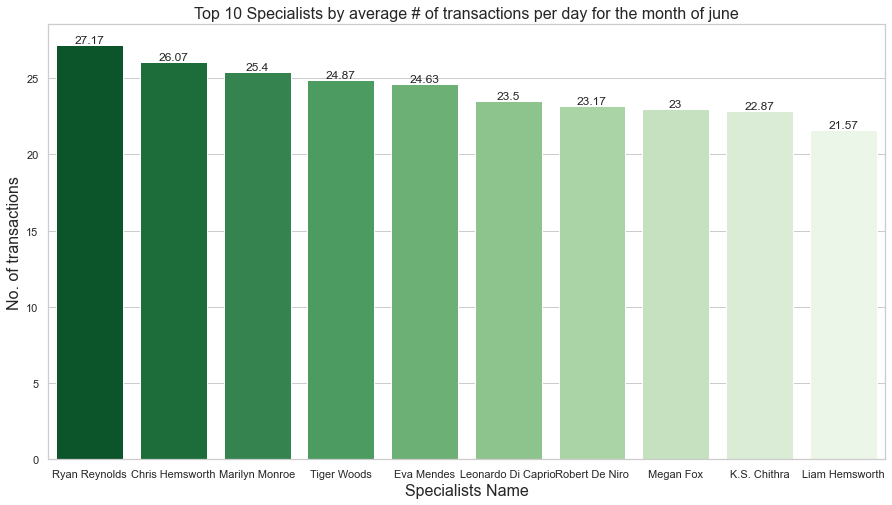

In [36]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid", color_codes=True)
splot=sns.barplot(x="full_name",y="Avg # of transactions per day",data=Count_Txns_name, palette='Greens_r')
plt.title('Top 10 Specialists by average # of transactions per day for the month of june', size=16)
plt.xlabel("Specialists Name", size=16)
plt.ylabel("No. of transactions", size=16)
plt.bar_label(splot.containers[0])
plt.savefig("annotate_barplot_with_Matplotlib_bar_label_Python.png")

There could be many factors which can impact the numbers which is not consider in the analysis because of the data and time limitation.<br>
For example:<br>
    - Specialists annual Leaves<br>
    - Public Holidays<br>

## 1.B  Customer Service Overview
#### Need to communicate to Workforce (WF) Management how much resources will be needed in the future, please determine how many members of staff will be needed per day of the week for the next 7 days.

In [14]:
# Counting of each unique specialist for each week and each day
resource_per_day = contacts.groupby(["Week_Number","Name_of_day"])['specialist_id'].nunique()
resource_per_day = pd.DataFrame(resource_per_day)
resource_per_day.rename(columns = {'specialist_id':'Count'}, inplace = True)
resource_per_day = resource_per_day.reset_index()
# Assigning number for each day to be used for sorting by day name
d=dict(enumerate(calendar.day_name))
d = {v: k for k, v in d.items()}
resource_per_day['Day_#'] = resource_per_day['Name_of_day'].map(d)
resource_per_day = resource_per_day.sort_values(by=['Day_#'], ascending=True)
resource_per_day.head(10)

,Week_Number,Name_of_day,Count,Day_#
22,26,Monday,112,0
1,23,Monday,106,0
15,25,Monday,127,0
28,27,Monday,123,0
8,24,Monday,136,0
12,24,Tuesday,132,1
19,25,Tuesday,135,1
29,27,Tuesday,117,1
5,23,Tuesday,132,1
26,26,Tuesday,120,1


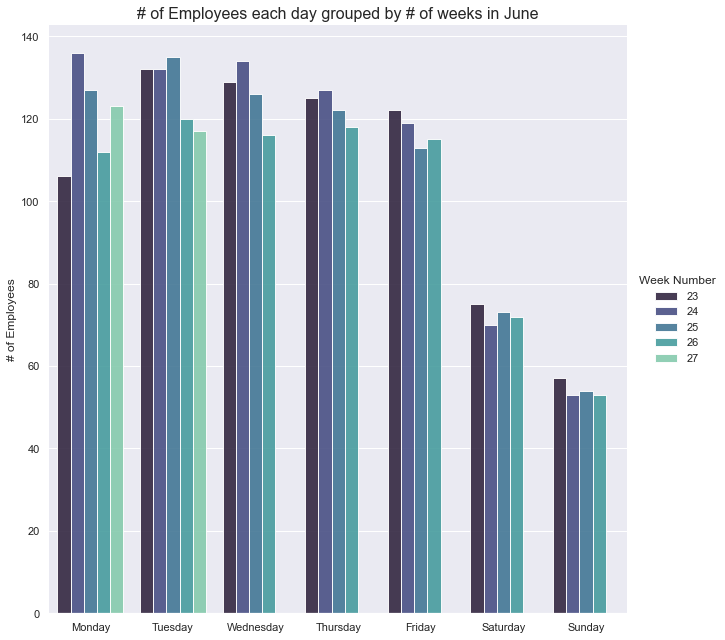

In [15]:
# Draw a nested barplot by Days and week
sns.set_theme(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.catplot(
    data=resource_per_day, kind="bar",
    x="Name_of_day", y="Count", hue="Week_Number",
    ci="sd", 
    palette="mako",
#    color='#46A793',
    alpha=.9, height=9)

g.despine(left=True)
g.set_axis_labels("", "# of Employees")
plt.title('# of Employees each day grouped by # of weeks in June', size=16)
g.legend.set_title("Week Number")

In [16]:
# Taking average count for each of the day
Average_resource_per_day =resource_per_day.groupby(["Name_of_day"])['Count'].mean()
Average_resource_per_day = pd.DataFrame(Average_resource_per_day)
Average_resource_per_day.rename(columns = {'Count':'Average # of Resource'}, inplace = True)
Average_resource_per_day = Average_resource_per_day.reset_index()

# Assigning number for each day to be used for sorting by day name
d=dict(enumerate(calendar.day_name))
d = {v: k for k, v in d.items()}
Average_resource_per_day['Day_#'] = Average_resource_per_day['Name_of_day'].map(d)
Average_resource_per_day = Average_resource_per_day.sort_values(by=['Day_#'], ascending=True)
Average_resource_per_day = Average_resource_per_day[["Name_of_day","Average # of Resource"]]
Average_resource_per_day["Average # of Resource"] = Average_resource_per_day["Average # of Resource"].round(2)
Average_resource_per_day


# Adding Header
styler = Average_resource_per_day.style.set_caption("Average resources required for each day").format(formatter={('Average # of Resource'): "{:.2f}"}).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', '#C00000'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

display(styler)

,Name_of_day,Average # of Resource
1,Monday,120.80
5,Tuesday,127.20
6,Wednesday,126.25
4,Thursday,123.00
0,Friday,117.25
2,Saturday,72.50
3,Sunday,54.25


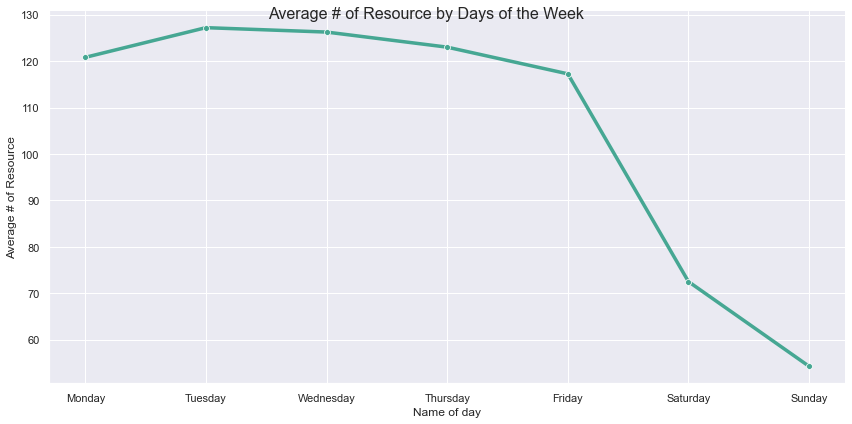

In [17]:
# plotting line chart for the Average resources required for each day data
b = sns.relplot(
    data=Average_resource_per_day, 
    x="Name_of_day", y="Average # of Resource", 
    kind="line",
    height=6, aspect=2,
    marker="o",
    linewidth = 3.5,
    color="#46A793",
)

b.fig.suptitle("Average # of Resource by Days of the Week",
                  fontsize=16)
b.set_axis_labels(x_var="Name of day", y_var="Average # of Resource")

## 2. CS Specialists
#### Weekly leaderboards:<br> <br> Breakdown per week for the top 5 inhouse CS specialists with respect to 3 KPIs for measuring specialist performance. Plot the leaderboards showing full names and scores.

The three KPI's took into consideration are agent satisfaction, csat, issue_resolved

In [18]:
# Joining surveys data with contacts data table to extract specialists ID and is In-House fields.
CS2_surveys_contacts = pd.merge(surveys,contacts[["id","specialist_id","is_inhouse"]],
                                how='left',left_on='contact_id',right_on='id')
# Only considering data where specialists are In-House
CS2_surveys_contacts = CS2_surveys_contacts[CS2_surveys_contacts["is_inhouse"]==True]
# Taking data where the week has all of the days(week # 27 has only two days so we ignore those data rows)
CS2_surveys_contacts = CS2_surveys_contacts[CS2_surveys_contacts.groupby(["Week_Number"])["Name_of_day"]
                                            .transform('nunique').ge(7)]
CS2_surveys_contacts

,contact_id,response_date,agent_satisfaction,csat,issue_resolved,Name_of_day,Week_Number,id,specialist_id,is_inhouse
3,c10770,2020-06-05 11:29:23,10,10,False,Friday,23,c10770,s104,True
4,c9547,2020-06-05 16:28:07,8,8,False,Friday,23,c9547,s148,True
6,c7884,2020-06-04 18:03:39,10,10,True,Thursday,23,c7884,s118,True
9,c9996,2020-06-05 08:02:32,10,9,True,Friday,23,c9996,s128,True
15,c9589,2020-06-05 06:11:52,10,9,True,Friday,23,c9589,s128,True
...,...,...,...,...,...,...,...,...,...,...
4469,c58897,2020-06-24 07:53:27,10,8,True,Wednesday,26,c58897,s114,True
4474,c58986,2020-06-24 07:09:15,10,10,True,Wednesday,26,c58986,s114,True
4475,c60190,2020-06-24 09:07:46,10,10,False,Wednesday,26,c60190,s162,True
4483,c59967,2020-06-24 08:56:35,9,9,True,Wednesday,26,c59967,s129,True


In [19]:
# For loop to iterate for each week
for i in CS2_surveys_contacts["Week_Number"].unique():
    CS2_surveys_contactss = CS2_surveys_contacts[CS2_surveys_contacts["Week_Number"]==i]
    # taking average mean of Agent satisfaction, Customer satisfaction for each week by specialists ID
    top_5_ac = CS2_surveys_contactss.groupby(['specialist_id',"Week_Number"])['agent_satisfaction','csat'].mean().reset_index()
    
    # processing data to consider count of issue resolved for each specialists
    top_5_ac_IR = CS2_surveys_contactss.groupby(['specialist_id','issue_resolved'])['issue_resolved'].count()
    top_5_ac_IR = pd.DataFrame(top_5_ac_IR)
    top_5_ac_IR.rename(columns = {'issue_resolved':'Count'}, inplace = True)
    top_5_ac_IR = top_5_ac_IR.reset_index()
    top_5_ac_IR['Total_Count'] = top_5_ac_IR['Count'].groupby(top_5_ac_IR['specialist_id']).transform('sum')
    top_5_ac_IR = top_5_ac_IR[top_5_ac_IR["issue_resolved"]==True]
    top_5_ac_IR['True_Percent'] = (top_5_ac_IR['Count']/top_5_ac_IR['Total_Count'])*100    
    
    # Now joining both table
    KPIS = pd.merge(top_5_ac,top_5_ac_IR[["True_Percent", "specialist_id"]],
                    how='left',on='specialist_id')    
    # dividing percentage by 10 equalize count data with Agent satisfaction, Customer satisfaction columns 
    KPIS["Issue resolved Percentiles"] = KPIS["True_Percent"]/ 10
    # calculating scores by dividing all 3 KPIS by to get an average
    KPIS["Score"] = KPIS["agent_satisfaction"]+KPIS["csat"]+KPIS["Issue resolved Percentiles"]/ 3
    KPIS = KPIS.sort_values(by=['Score'], ascending=False)[:5]
    KPIS = KPIS.drop(['True_Percent','Week_Number'], axis=1)

    # Now joining data table with specialists table to extract specialists full name
    Full_name_df = pd.merge(KPIS,specialists[["id", "full_name"]],
                                    how='left',left_on='specialist_id',right_on='id')
    Full_name_df = Full_name_df[['full_name', 'agent_satisfaction', 'csat', 'Issue resolved Percentiles', 'Score']]

# Adding Header(Title)
    styler = Full_name_df.style.set_caption("Top 5 CS Specialists based on the Customer, Agent Satisfiaction and Issue Resolved - For the week "+str(i)).set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', '#46A793'),
            ('font-size', '15px'),
            ('font-style', 'italic'),
            ('font-weight', 'bold'),
            ('text-align', 'center')
        ]
    }])
    
    display(styler)

,full_name,agent_satisfaction,csat,Issue resolved Percentiles,Score
0,Chris Pratt,10.000000,10.000000,10.000000,23.333333
1,Lindsay Lohan,10.000000,10.000000,10.000000,23.333333
2,Marilyn Monroe,10.000000,10.000000,10.000000,23.333333
3,Demi Moore,10.000000,10.000000,10.000000,23.333333
4,Drake,10.000000,10.000000,10.000000,23.333333


,full_name,agent_satisfaction,csat,Issue resolved Percentiles,Score
0,Chad Michael Murray,10.000000,10.000000,10.000000,23.333333
1,Paris Hilton,10.000000,10.000000,10.000000,23.333333
2,David Beckham,10.000000,10.000000,10.000000,23.333333
3,Cara Delevingne,10.000000,10.000000,10.000000,23.333333
4,Nina Dobrev,10.000000,10.000000,10.000000,23.333333


,full_name,agent_satisfaction,csat,Issue resolved Percentiles,Score
0,Jennifer Lopez,10.000000,10.000000,10.000000,23.333333
1,Demi Moore,10.000000,9.666667,10.000000,23.000000
2,Ashton Kutcher,10.000000,9.500000,10.000000,22.833333
3,Steven Spielberg,10.000000,9.500000,10.000000,22.833333
4,Ryan Gosling,10.000000,9.500000,10.000000,22.833333


,full_name,agent_satisfaction,csat,Issue resolved Percentiles,Score
0,Alyson Hannigan,10.000000,10.000000,10.000000,23.333333
1,Channing Tatum,10.000000,10.000000,10.000000,23.333333
2,Marlon Brando,10.000000,10.000000,10.000000,23.333333
3,Paul Walker,10.000000,10.000000,10.000000,23.333333
4,Blake Lively,10.000000,9.666667,10.000000,23.000000
